In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
import wget

import requests 
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 
import os

print('Libraries imported.')

Libraries imported.


In [3]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [4]:
wget.download('https://geo.nyu.edu/catalog/nyu_2451_34572', 'newyork_data.json')
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    nyc_data = json.load(json_data)

For the purpose of this project we just need the data stored in the 'features' key. We'll do the filter and then create and empty dataframe to feed the filtered data into it.

In [7]:
nyc_hoods = nyc_data['features']

In [8]:
columns_nyc = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=columns_nyc)
neighborhoods


,Borough,Neighborhood,Latitude,Longitude


In [9]:
for data in nyc_hoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Since we only want to see use Brooklyn for our analysis, we will filter data that corresponds to Brooklyn

In [11]:
neighborhoods.Borough.unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [12]:
brooklyn = neighborhoods.loc[neighborhoods['Borough']== 'Brooklyn'].reset_index(drop=True)

In [121]:
brooklyn.Neighborhood.count()
print('There are ' ,brooklyn.Neighborhood.count(), ' districts or neighbourhoods in Brooklyn' )
brooklyn.head()

There are  70  districts or neighbourhoods in Brooklyn


,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Get the geographical coordinates for Brooklyn

In [14]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Brooklyn are 40.6501038, -73.9495823.


In [15]:
brooklyn_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(brooklyn_map)  
    
brooklyn_map

We'll use the Foursquare API to get the top 100 venues in Brooklyn with a radius of 500m

In [16]:
CLIENT_ID = 'ERKPXISN1E2R544JDXMLWYT1CR2LSD0EVFZSW1DEQHBEQLJW' 
CLIENT_SECRET = '1XBF1B1P33020YPTO1OSHHR1DNJDRZCZFU00BAMPZUGHC3ML' 
VERSION = '20180605' 
LIMIT = 100 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ERKPXISN1E2R544JDXMLWYT1CR2LSD0EVFZSW1DEQHBEQLJW
CLIENT_SECRET:1XBF1B1P33020YPTO1OSHHR1DNJDRZCZFU00BAMPZUGHC3ML


In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues for item in venue])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
brooklyn_venues = getNearbyVenues(names=brooklyn['Neighborhood'],
                                   latitudes=brooklyn['Latitude'],
                                   longitudes=brooklyn['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [19]:
print(brooklyn_venues.shape)
brooklyn_venues.tail()

(2762, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2757,Erasmus,40.646926,-73.948177,NSA Food Market,40.646610,-73.945609,Grocery Store
2758,Erasmus,40.646926,-73.948177,ideal Fresh Market,40.647974,-73.943826,Grocery Store
2759,Erasmus,40.646926,-73.948177,Met Food,40.647400,-73.943565,Supermarket
2760,Erasmus,40.646926,-73.948177,MTA Bus - B35/B35LTD - Church Ave & New York Ave,40.651014,-73.946691,Bus Line
2761,Erasmus,40.646926,-73.948177,Crown Fried Chicken & Pizza,40.650773,-73.945402,Fried Chicken Joint


Lets check how many venues were returned for each neighbourhood and sort them by descending order of 'Venue'. There are six neighbourhoods that returned 100 venues -our limit

In [20]:
(brooklyn_venues.groupby('Neighborhood').count()).sort_values(by=['Venue'], ascending=False)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Carroll Gardens,100,100,100,100,100,100
South Side,100,100,100,100,100,100
Downtown,100,100,100,100,100,100
Brooklyn Heights,100,100,100,100,100,100
North Side,100,100,100,100,100,100
Greenpoint,100,100,100,100,100,100
Clinton Hill,93,93,93,93,93,93
Boerum Hill,90,90,90,90,90,90
Cobble Hill,89,89,89,89,89,89


In [21]:
#number of unique categories
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 289 uniques categories.


In [123]:
#analyse individual neighbourhoods

b_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

b_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

new_col = b_onehot['Neighborhood']
b_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
b_onehot.insert(0, 'Neighborhood', new_col)

b_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Use

In [23]:
b_onehot.shape

(2762, 289)

In [24]:
#lets group neighbourhoods by the mean of the categories

brooklyn_groups = b_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_groups.shape

(70, 289)

In [25]:
brooklyn_groups.head(20)

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Use

In [26]:
#lets find out the top 5 venues for each neighborhood
num_top_venues = 5

for hood in brooklyn_groups['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_groups[brooklyn_groups['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                venue  freq
0  Chinese Restaurant  0.04
1         Gas Station  0.04
2        Dessert Shop  0.04
3            Pharmacy  0.04
4     Bubble Tea Shop  0.04


----Bay Ridge----
                 venue  freq
0   Italian Restaurant  0.07
1                  Spa  0.06
2          Pizza Place  0.05
3     Greek Restaurant  0.04
4  American Restaurant  0.04


----Bedford Stuyvesant----
           venue  freq
0    Coffee Shop  0.11
1    Pizza Place  0.07
2           Café  0.07
3            Bar  0.07
4  Deli / Bodega  0.04


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.11
1  Italian Restaurant  0.08
2      Ice Cream Shop  0.06
3          Donut Shop  0.06
4         Pizza Place  0.06


----Bergen Beach----
             venue  freq
0  Harbor / Marina  0.29
1       Playground  0.14
2   Baseball Field  0.14
3             Park  0.14
4     Hockey Field  0.14


----Boerum Hill----
          venue  freq
0   Coffee Shop  0.06
1  Dance Studio  0.06
2

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
brooklyn_venues_sorted = pd.DataFrame(columns=columns)
brooklyn_venues_sorted['Neighborhood'] = brooklyn_groups['Neighborhood']

for ind in np.arange(brooklyn_groups.shape[0]):
    brooklyn_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_groups.iloc[ind, :], num_top_venues)

brooklyn_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Dessert Shop,Gas Station,Bubble Tea Shop,Cantonese Restaurant,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Donut Shop,Pizza Place
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Bar,American Restaurant,Greek Restaurant,Bagel Shop,Sushi Restaurant,Playground,Ice Cream Shop
2,Bedford Stuyvesant,Coffee Shop,Café,Pizza Place,Bar,Deli / Bodega,Bagel Shop,Fried Chicken Joint,New American Restaurant,Boutique,Gift Shop
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Park,Sushi Restaurant,Pizza Place,Ice Cream Shop,Donut Shop,Record Shop,Pet Store,Cosmetics Shop
4,Bergen Beach,Harbor / Marina,Hockey Field,Park,Baseball Field,Athletics & Sports,Playground,Food & Drink Shop,Food,Flower Shop,Food Court


We'll use K-means to cluster the neighbourhoods into 5 clusters

In [29]:
# set number of clusters
kclusters = 5

brooklyn_clustering = brooklyn_groups.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 3, 3, 3, 1, 1, 1, 3])

In [30]:
brooklyn_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn

# merge brooklyn dataframe with brooklyn_venues_sorted dataframe to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(brooklyn_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,3,Italian Restaurant,Spa,Pizza Place,Bar,American Restaurant,Greek Restaurant,Bagel Shop,Sushi Restaurant,Playground,Ice Cream Shop
1,Brooklyn,Bensonhurst,40.611009,-73.995180,3,Chinese Restaurant,Italian Restaurant,Park,Sushi Restaurant,Pizza Place,Ice Cream Shop,Donut Shop,Record Shop,Pet Store,Cosmetics Shop
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Mobile Phone Shop,Bakery,Pizza Place,Mexican Restaurant,Latin American Restaurant,Bank,Fried Chicken Joint,Gym,Deli / Bodega,Ice Cream Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,3,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Yoga Studio,French Restaurant,Record Shop,Mexican Restaurant,Deli / Bodega,Bakery
4,Brooklyn,Gravesend,40.595260,-73.973471,3,Pizza Place,Bakery,Lounge,Italian Restaurant,Gym,Chinese Restaurant,Men's Store,Baseball Field,Bar,Cosmetics Shop


In [31]:
brooklyn_merged.groupby('Cluster Labels').count()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,34,34,34,34,34,34,34,34,34,34,34,34,34,34
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,33,33,33,33,33,33,33,33,33,33,33,33,33,33
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [32]:
# create map
brooklyn_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(brooklyn_map_clusters)
       
brooklyn_map_clusters

In [33]:
#cluster 1
cluster1=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
cluster1.Neighborhood.count()

1

In [34]:
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,Pool,Yoga Studio,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food


In [35]:
#cluster 2
cluster2=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
cluster2.Neighborhood.count()

34

In [36]:
#cluster 3
cluster3=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
cluster3.Neighborhood.count()

1

In [37]:
#cluster 4
cluster4=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
cluster4.Neighborhood.count()

33

In [38]:
#cluster 5
cluster5=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
cluster5.Neighborhood.count()

1

Summary of the 5 clusters in Brooklyn
- cluster 1 has 1 neighbourhood
- cluster 2 has 35 neighbourhoods
- cluster 3 has 1 neighbourhood
- cluster 4 has 32 neighbourhoods
- cluster 5 has 1 neighbourhood

Now let's look at cluster 2 and cluster 4 in more detail. We could look at the different types of venues available in each cluster and also their respective real estate prices.

In [39]:
venue_df_c4=pd.DataFrame(cluster4['1st Most Common Venue'].value_counts()).reset_index()
venue_df_c4.rename(columns={'index':'Venue Type', '1st Most Common Venue':'Count'}, inplace=True)
venue_df_c4

,Venue Type,Count
0,Coffee Shop,5
1,Italian Restaurant,5
2,Bar,4
3,Pizza Place,3
4,Park,2
5,Deli / Bodega,2
6,Food Truck,1
7,Chinese Restaurant,1
8,Turkish Restaurant,1
9,Dance Studio,1


In [40]:
venue_df_c2=pd.DataFrame(cluster2['1st Most Common Venue'].value_counts()).reset_index()
venue_df_c2.rename(columns={'index':'Venue Type', '1st Most Common Venue':'Count'}, inplace=True)
venue_df_c2

,Venue Type,Count
0,Pizza Place,5
1,Bank,4
2,Grocery Store,2
3,Caribbean Restaurant,2
4,Pharmacy,2
5,Deli / Bodega,2
6,Donut Shop,2
7,Monument / Landmark,1
8,Mobile Phone Shop,1
9,Chinese Restaurant,1


In [114]:
c2c4_df = pd.merge(venue_df_c2, venue_df_c4, left_on='Venue Type', right_on='Venue Type', how='left') 
c2c4_df.fillna(0, inplace=True)
c2c4_df.rename(columns={'Count_x': 'Cluster2', 'Count_y':'Cluster4'}, inplace=True)
c2c4_df.head(10)


,Venue Type,Cluster2,Cluster4
0,Pizza Place,5,3.0
1,Bank,4,0.0
2,Grocery Store,2,0.0
3,Caribbean Restaurant,2,0.0
4,Pharmacy,2,0.0
5,Deli / Bodega,2,2.0
6,Donut Shop,2,0.0
7,Monument / Landmark,1,0.0
8,Mobile Phone Shop,1,0.0
9,Chinese Restaurant,1,1.0


In [134]:
c2c4_df['Cluster4']=c2c4_df['Cluster4'].astype(int)
c2c4_df.head(10)

,Venue Type,Cluster2,Cluster4
0,Pizza Place,5,3
1,Bank,4,0
2,Grocery Store,2,0
3,Caribbean Restaurant,2,0
4,Pharmacy,2,0
5,Deli / Bodega,2,2
6,Donut Shop,2,0
7,Monument / Landmark,1,0
8,Mobile Phone Shop,1,0
9,Chinese Restaurant,1,1


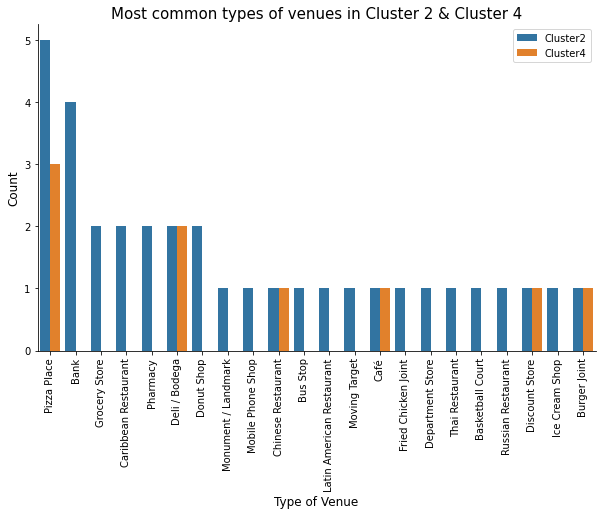

In [127]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(10, 6))

tidy = c2c4_df.melt(id_vars='Venue Type').rename(columns=str.title)
sns.barplot(x='Venue Type', y='Value', hue='Variable', data=tidy, ax=ax1)

plt.xticks(rotation=90)
plt.xlabel('Type of Venue', size =12)
plt.ylabel('Count',  size =12)
plt.title('Most common types of venues in Cluster 2 & Cluster 4', size=15)
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()


## Real estate prices in Brooklyn

In [44]:
df = pd.read_csv('/Users/BGrigaut.ELITHIS/Documents/data analysis related/IBM SQL/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [45]:
test=df.loc[df['SALE PRICE']==' -  ']

In [46]:
df['SALE PRICE'] = df['SALE PRICE'].replace(' -  ',0)

In [47]:
df['SALE PRICE']=df['SALE PRICE'].astype('float64')

In [48]:
mean =df['SALE PRICE'].mean()

In [49]:
df['SALE PRICE'] = df['SALE PRICE'].replace(0,mean)

As before, we just need the data for Brooklyn

In [50]:
df_brook=df.loc[df['BOROUGH']==3]
df_brook.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
25355,4,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6360,157,,A5,36 BAY 10TH STREET,,11228,1,0,1,1547,1428,1930,1,A5,8.000000e+05,2017-02-27 00:00:00
25356,5,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6361,20,,A5,47 BAY 10TH STREET,,11228,1,0,1,1933,1660,1930,1,A5,1.056623e+06,2017-03-04 00:00:00
25357,6,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6364,2,,A5,1649 BENSON AVENUE,,11214,1,0,1,1638,972,1930,1,A5,1.056623e+06,2016-10-06 00:00:00
25358,7,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6367,42,,S1,1730 86TH STREET,,11214,1,1,2,1342,1920,1926,1,S1,1.200000e+06,2017-03-31 00:00:00
25359,8,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6374,67,,S1,8642 20TH AVENUE,,11214,1,1,2,1740,3240,1925,1,S1,1.090000e+06,2016-10-24 00:00:00


In [51]:
avg_price=df_brook.groupby('NEIGHBORHOOD').mean()
new_df = pd.DataFrame(avg_price)
new_df.head()

,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
NEIGHBORHOOD,,,,,,,,,,,
BATH BEACH,139.5,3.0,6416.691176,235.411765,11176.375000,1.819853,0.091912,1.974265,1810.205882,1.422794,9.468275e+05
BAY RIDGE,691.5,3.0,5989.299279,114.849760,11211.463942,1.474760,0.120192,1.609375,1875.489183,1.570913,8.993283e+05
BEDFORD STUYVESANT,1825.5,3.0,1777.352368,316.194986,11054.105850,2.627437,0.123955,2.777159,1741.951253,1.565460,1.206548e+06
BENSONHURST,2831.5,3.0,6127.296875,142.774306,11193.295139,2.364583,0.128472,2.512153,1838.284722,1.395833,1.108389e+06
BERGEN BEACH,3216.5,3.0,8397.984536,379.396907,11234.000000,1.448454,0.010309,1.530928,1716.979381,1.304124,7.981612e+05


We will drop all the unnecessary columns.

In [52]:
new_df.drop(columns = ['Unnamed: 0', 'BLOCK', 'LOT', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE'], inplace=True)

In [53]:
new_df.reset_index(inplace=True)
new_df.head()

,NEIGHBORHOOD,BOROUGH,SALE PRICE
0,BATH BEACH,3.0,9.468275e+05
1,BAY RIDGE,3.0,8.993283e+05
2,BEDFORD STUYVESANT,3.0,1.206548e+06
3,BENSONHURST,3.0,1.108389e+06
4,BERGEN BEACH,3.0,7.981612e+05


In [79]:
new_df['NEIGHBORHOOD']=new_df.NEIGHBORHOOD.str.title()
new_df.head()

,NEIGHBORHOOD,BOROUGH,SALE PRICE
0,Bath Beach,3.0,946827
1,Bay Ridge,3.0,899328
2,Bedford Stuyvesant,3.0,1206547
3,Bensonhurst,3.0,1108388
4,Bergen Beach,3.0,798161


In [75]:
#merging the cluster 4 neighbourhoods wiht the real estate dataframe
cluster4_re=pd.merge(cluster4,new_df, left_on='Neighborhood', right_on='NEIGHBORHOOD', how='left')
cluster4_re.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,NEIGHBORHOOD,BOROUGH,SALE PRICE
0,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Bar,American Restaurant,Greek Restaurant,Bagel Shop,Sushi Restaurant,Playground,Ice Cream Shop,Bay Ridge,3.0,899328.0
1,Bensonhurst,Chinese Restaurant,Italian Restaurant,Park,Sushi Restaurant,Pizza Place,Ice Cream Shop,Donut Shop,Record Shop,Pet Store,Cosmetics Shop,Bensonhurst,3.0,1108388.0
2,Greenpoint,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Yoga Studio,French Restaurant,Record Shop,Mexican Restaurant,Deli / Bodega,Bakery,Greenpoint,3.0,1389893.0
3,Gravesend,Pizza Place,Bakery,Lounge,Italian Restaurant,Gym,Chinese Restaurant,Men's Store,Baseball Field,Bar,Cosmetics Shop,Gravesend,3.0,901823.0
4,Sheepshead Bay,Turkish Restaurant,Dessert Shop,Sandwich Place,Yoga Studio,Diner,Russian Restaurant,Restaurant,Creperie,Pizza Place,Buffet,Sheepshead Bay,3.0,889346.0


In [76]:
cluster4_re.drop(columns=['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'], inplace=True)

In [84]:
#average real estate price in cluster 4
avg_re_c4 = cluster4_re['SALE PRICE'].mean()
print('The average real estate price for Cluster 4 is : ', round(avg_re_c4, 2))

The average real estate price for Cluster 4 is :  1369005.59


Let's merge cluster 2 df with the real estate df to get the average real estate price in cluster 2

In [90]:
cluster2_re=pd.merge(cluster2,new_df, left_on='Neighborhood', right_on='NEIGHBORHOOD', how='left')
cluster2_re.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,NEIGHBORHOOD,BOROUGH,SALE PRICE
0,Sunset Park,Mobile Phone Shop,Bakery,Pizza Place,Mexican Restaurant,Latin American Restaurant,Bank,Fried Chicken Joint,Gym,Deli / Bodega,Ice Cream Shop,Sunset Park,3.0,1241237.0
1,Brighton Beach,Russian Restaurant,Restaurant,Eastern European Restaurant,Gourmet Shop,Beach,Sushi Restaurant,Mobile Phone Shop,Pharmacy,Food & Drink Shop,Playground,Brighton Beach,3.0,827767.0
2,Manhattan Terrace,Ice Cream Shop,Pizza Place,Chinese Restaurant,Donut Shop,Liquor Store,Bakery,Grocery Store,Coffee Shop,Bus Stop,Mobile Phone Shop,NaN,NaN,NaN
3,Flatbush,Bank,Mexican Restaurant,Caribbean Restaurant,Deli / Bodega,Coffee Shop,Hardware Store,Bagel Shop,Middle Eastern Restaurant,Juice Bar,Sandwich Place,NaN,NaN,NaN
4,Crown Heights,Pizza Place,Museum,Café,Bakery,Sushi Restaurant,Liquor Store,Salon / Barbershop,Coffee Shop,Supermarket,Kosher Restaurant,Crown Heights,3.0,1151414.0


In [91]:
cluster2_re.drop(columns=['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'], inplace=True)

In [130]:
avg_re_c2= cluster2_re['SALE PRICE'].mean()
print('The average real estate price for Cluster 2 is : ', round(avg_re_c2, 2))


The average real estate price for Cluster 2 is :  940792.0


In [98]:
#create a df showing the real estate prices in the 2 clusters so that we can put it on a visual
data = [['Cluster 2',round(avg_re_c2, 2) ], ['Cluster 4', round(avg_re_c4, 2)]]
real_df = pd.DataFrame(data, columns = ['Cluster', 'Avg Price']) 
real_df

,Cluster,Avg Price
0,Cluster 2,940792.00
1,Cluster 4,1369005.59


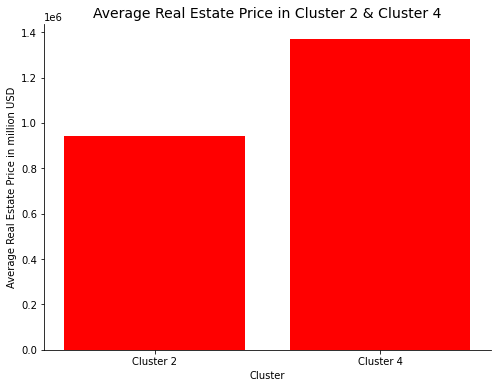

In [110]:
ax = plt.subplots(figsize=(8, 6))

plt.bar(real_df['Cluster'], real_df['Avg Price'], color='red')
#plt.xlabel('Cluster', size =10)
plt.ylabel('Average Real Estate Price in million USD',  size =10)
plt.title('Average Real Estate Price in Cluster 2 & Cluster 4', size=14)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

When we compare the venues and real estate prices in the neighbourhoods of the two clusters, we can see that
    - Cluster 2 has a lot more variety of venues than cluster 4.
    - Real estate is cheaper in the neighbourhoods of cluster 2 than cluster 4. 
   
This would mean that the quality of life in cluster 2 would be better in cluster 2 neighbourhoods than in cluster 4 neighbourhoods. So my recommendation would be to consider a neighbourhood in cluster 2. 

###### Thank you!